In [ ]:
%pip install labml_helpers
%pip install labml_nn

In [ ]:
import numpy as np                                                                                                                                  
import matplotlib.pyplot as plt
import math
import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch.optim import Adam
from tqdm.auto import tqdm
import os
from datetime import datetime
from math import sqrt 
from typing import Optional, Tuple
from labml_helpers.module import Module
from labml_nn.lstm import LSTMCell          

In [ ]:
# --------- VAE PARAMETERS --------------

stroke_dim = 5

# decoder https://arxiv.org/pdf/1704.03477.pdf
M = 20 # number of normal distributions for output 
T = 1# temperature parameter
# saves computation

latent_dim = 128
feature_dim = 32
dec_hyper_dim = 64
dec_hidden_dim = 2048 # dimension of cell and hidden states
enc_hidden_dim = 512 # dimension of cell and hidden states

# --------- TRAINING PARAMETERS ----------

lr = 7e-5# Used to be 2e-3 but got NaN gradients
batch_size =  70# batch_size >= 1, used to be 128
conditional = True
n_epochs = 10
w_kl = 0.99 # weight for loss calculation, can be tuned if needed
anneal_loss = True # True if train using annealed kl loss, False otherwise
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Hyperparameters for annealing loss
n_min = 0.01  # Starting Value from paper
R = 0.9999  # R is a term close to but less than 1.
KL_min = 0.2 # Value from paper (needs to be between 0.1 and 0.5)

# --------- DATA LOADING -----------------

#from python.pruning import prune_data 

# File paths for sketch data
#datapaths = ["data/banana.npz","data/apple.npz"]

datapaths = [
  "data/remote/apple.npz",
  "data/remote/flower.npz",
  "data/remote/cactus.npz",
  "data/remote/carrot.npz"
    ]

Nclass = len(datapaths) 

In [ ]:
def prune_data(data, num_std=2.5):
    """
    Given a .npz file loaded in numpy arrays, prune the dataset based on its mean, std,
    and a user-specified number of std (default is 2.5).

    Parameters:
        - data: a .npz file loaded in as numpy arrays.
        - num_std: optional int for specifying how many images should be pruned.
                    As num_std increases, less images are pruned, and vice versa.
                    This should be a value between 0 and 3.

    Returns:
         - none
    """
    # get initial # of images
    print(f"Initial number of images: {np.size(data)}")

    # Get mean + std
    data_val = np.zeros(0)
    for i in data:
        data_val = np.append(data_val, [len(i)])
    mean = np.mean(data_val)
    std = np.std(data_val)

    lower = math.floor(mean - std*num_std)  # the lower bound of points allowed
    upper = math.ceil(mean + std*num_std) # the upper bound of points allowed

    i = 0
    while i < np.size(data):
        num_points = np.shape(data[i])[0] # gets number of points
        if num_points < lower or num_points > upper:
            data = np.delete(data, i)
        else:
            i += 1

    # get final # of images
    print(f"Number of images after pruning: {np.size(data)}")

In [ ]:
datasets = [np.load(path, encoding='latin1', allow_pickle=True) for path in datapaths]

for dataset in datasets:
  prune_data(dataset["train"],1.5)
  prune_data(dataset["test"],1.5)

Nmax = max([
  max([len(i) for i in dataset["train"]] + [len(i) for i in dataset["test"]]) 
  for dataset in datasets
  ])

In [ ]:
def encode_sketch(sketch,length,N,do_offset = True): 
    ''' 
    One-hot encode pen state by adding additional columns for pen up and end of stroke.

    Parameters: 
        sketch (ndarray): n*4 array with format (x,y,p1,class), representing sketch data

    Returns: 
        ndarray: n*5 array with format (x,y,p1,p2,p3, c1,...,c_N), where p2 = 1-p1 and p3 is 1 at 
        end of the sketch, 0 otherwise.
    '''
    if do_offset:
        sketch[:,:2] *= np.random.uniform(0.9, 1.1, size=(Nmax, 2))


    shape = sketch.shape
    pen_up = (np.ones(shape[0]) - sketch[:,2]).reshape(shape[0],1)
    
    end_stroke = np.zeros((shape[0],1))
    end_stroke[length:] = 1 
    pen_up[length:] = 0
    sketch[:,2][length:] = 0
    sketch[-1][2] = 0
    
    if N > 0:
        category = np.zeros((shape[0],N))
        category[:,int(sketch[0][-1])] = 1
        return np.concatenate((sketch[:,:-1],pen_up,end_stroke,category),axis=1)
    else: 
        return np.concatenate((sketch[:,:-1],pen_up,end_stroke),axis=1)


In [ ]:
def encode_dataset1(data,lengths,do_offset = True,N = Nclass):
    """
    Encode pen states by creating a new array of sketch data.
    
    Parameters:
        data (iterable): object containing data for each sketch
        
    Returns:
        ndarray: object array containing encoded data for each sketch
    """
    # new_data = np.empty(data.size,dtype=object)
    new_data = np.empty((data.shape[0], data.shape[1], stroke_dim+N), dtype=object)

    for i, sketch in enumerate(data):
        new_data[i] = encode_sketch(sketch,lengths[i],N,do_offset)

    return new_data

In [ ]:
class SketchesDataset():
    def __init__(self, datasets, mode, transform=None):
        """
        data_path: The path to the data
        mode: Either 'train' or 'test'
        """
        self.transform = transform
        self.mode = mode
        self.data_set = []
        for i, dataset in enumerate(datasets):
            dataset = dataset[mode]
            dataset = normalize_data(dataset)
            for j, sketch in enumerate(dataset):
                sketch_class = np.full((len(sketch), 1), i)
                sketch = np.concatenate([sketch, sketch_class], 1)
                self.data_set.append(sketch)

    def __len__(self):
        return len(self.data_set)

    def __getitem__(self, idx):
        sketch = self.data_set[idx]
        if self.transform:
            sketch, length = self.transform(sketch)
        return sketch, length

In [ ]:
def normalize_data(data):

    total_length = 0
    

    for element in data:
        total_length += (len(element))


    coordinate_list = np.empty((total_length,2))

    i = 0

    for element in data:
        coordinate_list[i:i+len(element),:] = element[:,0:2]
        i+=len(element)

    data_std = np.std(coordinate_list)

    for i, element in enumerate(data):
        data[i] = data[i].astype(np.float32)
        data[i][:,0:2] = element[:,0:2].astype(np.float32)/data_std
    
    return data

In [ ]:
def display_encoded_image(image):
    """
    For some image tensor, draw the image using matplotlib.

    Parameters:
        - image: some [n*5] tensor representing a sketch.
    Returns:
        - none
    """
    #Xplot and Yplot are array of points that will be plotted
    Xplot = [0]
    Yplot = [0]
    #Keeps track of the current point that is being drawn
    xpos = 0
    ypos = 0
    #For loop to go through data and plot points
    i=0
    for i in range(len(image)):
        xpos += float(image[i,0])
        ypos += float(image[i,1])
        Xplot.append(-xpos)
        Yplot.append(-ypos)
        if image[i,3] == 0:
            plt.plot(Xplot, Yplot,color='black')
            Xplot.clear()
            Yplot.clear()
        # elif image[i, 4] == 1:
    ax = plt.gca()
    ax.set_aspect('equal', adjustable='box')
    ax.axis('off')
    plt.show()

In [ ]:
def kl_loss(sigma_hat, mu):
    # torch.sum is added to sum over all the dimensions of the vectors
    return (-0.5 / (latent_dim * batch_size)) * torch.sum(1 + sigma_hat - torch.square(mu) - torch.exp(sigma_hat))

In [ ]:
def make_image(image):
    length = len(image)
    new_image = np.zeros((Nmax, 4))
    new_image[:len(image), :] = image[:len(image), :] # copy over values
    if conditional:
        # don't forget to stack input along dim = 1
        encoded_strokes = np.stack(encode_dataset1(np.array([new_image]),[length]), 1) 
    else:
        encoded_strokes = np.stack(encode_dataset1(np.array([new_image]),[length],N=0), 1) 
    batch = torch.from_numpy(encoded_strokes.astype(float))
    return batch, torch.tensor(length)

In [ ]:
def make_batch(size=batch_size):
    """
    Using the data created earlier in the code and a given batch size, randomly fetch
    that many images and return them + their lengths.

    Parameters:
        - size: the size of the batch. Default is the variable batch_size declared
            at the start of the code.

    Returns:
        - batch: a tensor of the batch of random images appended in the order they were fetched in.
        - lengths: the length of each image fetched, in the order they were fetched in.
    """

    batch_ids = np.random.choice(len(data), size)
    batch_images = [data[id] for id in batch_ids]
    lengths = [len(image) for image in batch_images]
    strokes = []
    for image in batch_images:
        new_image = np.zeros((Nmax, 3))
        new_image[:len(image), :] = image[:len(image), :] # copy over values
        strokes.append(new_image)

    encoded_strokes = np.stack(encode_dataset1(np.array(strokes),lengths), 1) # don't forget to stack input along dim = 1
    batch = torch.from_numpy(encoded_strokes.astype(float))
    return batch, torch.tensor(lengths)

In [ ]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        if conditional:
            self.input_dim = stroke_dim + Nclass
        else:
            self.input_dim = stroke_dim

        self.lstm = nn.LSTM(self.input_dim, enc_hidden_dim, bidirectional=True)

        self.fc_mu = nn.Linear(2*enc_hidden_dim, latent_dim)
        self.fc_sigma = nn.Linear(2*enc_hidden_dim, latent_dim)

    def forward(self, x):
        """
        Runs a batch of images through the encoder and returns its latent vector.
        Does not normalize values on its own.

        Parameters:
         - x: Tensor of shape [max_strokes, batch_size, num_features]
            where max_strokes is the highest number of points possible for an image in the batch.
            x should be normalized.
        - batch_size: int representing the current batch size.

        Returns:
        - mu: Tensor of shape [batch_size, 2*hidden dim] representing the mean of the distribution of values
        - sigma: Tensor of shape [batch_size, 2*hidden dim] representing the log of the distribution of values
        """

        # Get the hidden states
        hidden, cell = torch.zeros(2, (batch_size), enc_hidden_dim,device=device), torch.zeros(2, (batch_size), enc_hidden_dim,device=device)

        _, (hidden, cell) = self.lstm(x.float(), (hidden, cell))
        hidden_forward_dir, hidden_backward_dir = torch.split(hidden, 1, 0)
        hidden_concatenated = torch.cat([hidden_forward_dir.squeeze(0), hidden_backward_dir.squeeze(0)], 1)

        mu = self.fc_mu(hidden_concatenated)
        sigma = self.fc_sigma(hidden_concatenated)
        return mu, sigma

encoder = Encoder()

In [ ]:
def gaussian_mixture_model(mixture_weights, mean_x, mean_y, std_x, std_y, corr_xy):
    """
    Input:
        mixture_weights: Mixture weights (probability of a point being in distribution i)
        mean_x: The x-values of the means of each distribution
        mean_y: The y-values of the means of each distribution
        std_x: The standard deviations of the x-values
        std_y: The standard deviations of the y-values
        corr_xy: The correlation coefficients of the x and y values
        
    Return: 
        The sampled x and y offsets
    """
    # Choose which distribution to sample from
    mixture_weights = torch.reshape(mixture_weights,(batch_size,M)).contiguous() 
     
    # Index for each batch
    i = torch.searchsorted(mixture_weights.cumsum(0), torch.rand(batch_size, 1)).squeeze()
    
    # Sample from bivariate normal distribution i
    rand_x, rand_y = torch.randn(batch_size), torch.randn(batch_size)
    
    mean_x = torch.take(mean_x, i)
    mean_y = torch.take(mean_y, i)
    std_x = torch.take(std_x, i)
    std_y = torch.take(std_y, i)
    corr_xy = torch.take(corr_xy, i)
    
    # Alternatively torch.distributions.multivariate_normal.MultivariateNormal?
    offset_x = mean_x + std_x * rand_x
    offset_y = mean_y + std_y * (corr_xy * offset_x + torch.sqrt(1 - corr_xy ** 2) * rand_y)
    return offset_x.unsqueeze(0), offset_y.unsqueeze(0)

In [ ]:
def sample(mixture_weights, mean_x, mean_y, std_x, std_y, corr_xy, pen_state):
    offset_x, offset_y = gaussian_mixture_model(mixture_weights, mean_x, mean_y, std_x, std_y, corr_xy)
    
    pen_state = pen_state.squeeze()
    pen_state = torch.searchsorted(pen_state.cumsum(1), torch.rand(batch_size, 1)).squeeze()
    next_point = torch.cat((offset_x, offset_y, torch.zeros(3, batch_size)))
    next_point = torch.cat((offset_x, offset_y, torch.eye(3)[pen_state].transpose(0, 1)))
    return next_point.transpose(0, 1)


In [ ]:
def distribution(decoder_output):
    """
    Input: 
        decoder_output (6M + 3): Decoder LSTM output
    Return:
        mixture_weights (M): Mixture weights (probability of a point being in distribution i)
        mean_x (M): The x-values of the means of each distribution
        mean_y (M): The y-values of the means of each distribution
        std_x (M): The standard deviations of the x-values
        std_y (M): The standard deviations of the y-values
        corr_xy (M): The correlation coefficients of the x and y values
        q (3): The predicted pen state (pen_down, pen_up, <EOS>)
    """
    sqrtT = sqrt(T)
    # Split the decoder output into 
    # [pi, mean_x, mean_y, std_x, std_y, rho_xy] and [q1,q2,q3]
    parameters = torch.split(decoder_output, 6, 2)

    # Chunk the parameters together, then stack them 
    # so that each column defines a distribution
    mixture_parameters = torch.stack(parameters[:-1],1)

    # Split mixture parameters into each parameter
    mixture_weights, mean_x, mean_y, std_x, std_y, corr_xy = torch.split(mixture_parameters, 1, 3)

    # The 3 leftover parameters are for the pen state
    pen_state = parameters[-1]

    mixture_weights = F.softmax(mixture_weights/T,dim=3)  # Each weight must be in [0, 1] and all must sum to 1
    std_x = torch.exp(std_x)*sqrtT  # Standard deviation must be positive
    std_y = torch.exp(std_y)*sqrtT  # Standard deviation must be positive
    corr_xy = F.tanh(corr_xy)  # Correlation coefficient must be in [-1, 1]
    pen_state = F.softmax(pen_state/T,dim=2)  # Each probability must be in [0, 1] and all must sum to 1

    return mixture_weights, mean_x, mean_y, std_x, std_y, corr_xy, pen_state

In [ ]:
class HyperLSTMCell(Module):
    """
    ## HyperLSTM Cell

    For HyperLSTM the smaller network and the larger network both have the LSTM structure.
    This is defined in Appendix A.2.2 in the paper.
    """

    def __init__(self, input_size: int, hidden_size: int, hyper_size: int, n_z: int):
        """
        `input_size` is the size of the input $x_t$,
        `hidden_size` is the size of the LSTM, and
        `hyper_size` is the size of the smaller LSTM that alters the weights of the larger outer LSTM.
        `n_z` is the size of the feature vectors used to alter the LSTM weights.

        We use the output of the smaller LSTM to compute $z_h^{i,f,g,o}$, $z_x^{i,f,g,o}$ and
        $z_b^{i,f,g,o}$ using linear transformations.
        We calculate $d_h^{i,f,g,o}(z_h^{i,f,g,o})$, $d_x^{i,f,g,o}(z_x^{i,f,g,o})$, and
        $d_b^{i,f,g,o}(z_b^{i,f,g,o})$ from these, using linear transformations again.
        These are then used to scale the rows of weight and bias tensors of the main LSTM.

        📝 Since the computation of $z$ and $d$ are two sequential linear transformations
        these can be combined into a single linear transformation.
        However we've implemented this separately so that it matches with the description
        in the paper.
        """
        super().__init__()

        # The input to the hyperLSTM is
        # $$
        # \hat{x}_t = \begin{pmatrix}
        # h_{t-1} \\
        # x_t
        # \end{pmatrix}
        # $$
        # where $x_t$ is the input and $h_{t-1}$ is the output of the outer LSTM at previous step.
        # So the input size is `hidden_size + input_size`.
        #
        # The output of hyperLSTM is $\hat{h}_t$ and $\hat{c}_t$.
        self.hyper = LSTMCell(hidden_size + input_size, hyper_size, layer_norm=True)

        # $$z_h^{i,f,g,o} = lin_{h}^{i,f,g,o}(\hat{h}_t)$$
        # 🤔 In the paper it was specified as
        # $$z_h^{i,f,g,o} = lin_{h}^{i,f,g,o}(\hat{h}_{\textcolor{red}{t-1}})$$
        # I feel that it's a typo.
        self.z_h = nn.Linear(hyper_size, 4 * n_z)
        # $$z_x^{i,f,g,o} = lin_x^{i,f,g,o}(\hat{h}_t)$$
        self.z_x = nn.Linear(hyper_size, 4 * n_z)
        # $$z_b^{i,f,g,o} = lin_b^{i,f,g,o}(\hat{h}_t)$$
        self.z_b = nn.Linear(hyper_size, 4 * n_z, bias=False)

        # $$d_h^{i,f,g,o}(z_h^{i,f,g,o}) = lin_{dh}^{i,f,g,o}(z_h^{i,f,g,o})$$
        d_h = [nn.Linear(n_z, hidden_size, bias=False) for _ in range(4)]
        self.d_h = nn.ModuleList(d_h)
        # $$d_x^{i,f,g,o}(z_x^{i,f,g,o}) = lin_{dx}^{i,f,g,o}(z_x^{i,f,g,o})$$
        d_x = [nn.Linear(n_z, hidden_size, bias=False) for _ in range(4)]
        self.d_x = nn.ModuleList(d_x)
        # $$d_b^{i,f,g,o}(z_b^{i,f,g,o}) = lin_{db}^{i,f,g,o}(z_b^{i,f,g,o})$$
        d_b = [nn.Linear(n_z, hidden_size) for _ in range(4)]
        self.d_b = nn.ModuleList(d_b)

        # The weight matrices $W_h^{i,f,g,o}$
        self.w_h = nn.ParameterList([nn.Parameter(torch.zeros(hidden_size, hidden_size)) for _ in range(4)])
        # The weight matrices $W_x^{i,f,g,o}$
        self.w_x = nn.ParameterList([nn.Parameter(torch.zeros(hidden_size, input_size)) for _ in range(4)])

        # Layer normalization
        self.layer_norm = nn.ModuleList([nn.LayerNorm(hidden_size) for _ in range(4)])
        self.layer_norm_c = nn.LayerNorm(hidden_size)

    def forward(self, x: torch.Tensor,
                h: torch.Tensor, c: torch.Tensor,
                h_hat: torch.Tensor, c_hat: torch.Tensor):
        # $$
        # \hat{x}_t = \begin{pmatrix}
        # h_{t-1} \\
        # x_t
        # \end{pmatrix}
        # $$
        x_hat = torch.cat((h, x), dim=-1)
        # $$\hat{h}_t, \hat{c}_t = lstm(\hat{x}_t, \hat{h}_{t-1}, \hat{c}_{t-1})$$
        h_hat, c_hat = self.hyper(x_hat, h_hat, c_hat)

        # $$z_h^{i,f,g,o} = lin_{h}^{i,f,g,o}(\hat{h}_t)$$
        z_h = self.z_h(h_hat).chunk(4, dim=-1)
        # $$z_x^{i,f,g,o} = lin_x^{i,f,g,o}(\hat{h}_t)$$
        z_x = self.z_x(h_hat).chunk(4, dim=-1)
        # $$z_b^{i,f,g,o} = lin_b^{i,f,g,o}(\hat{h}_t)$$
        z_b = self.z_b(h_hat).chunk(4, dim=-1)

        # We calculate $i$, $f$, $g$ and $o$ in a loop
        ifgo = []
        for i in range(4):
            # $$d_h^{i,f,g,o}(z_h^{i,f,g,o}) = lin_{dh}^{i,f,g,o}(z_h^{i,f,g,o})$$
            d_h = self.d_h[i](z_h[i])
            # $$d_x^{i,f,g,o}(z_x^{i,f,g,o}) = lin_{dx}^{i,f,g,o}(z_x^{i,f,g,o})$$
            d_x = self.d_x[i](z_x[i])

            # \begin{align}
            # {i,f,g,o} = LN(&\textcolor{lightgreen}{d_h^{i,f,g,o}(z_h) \odot (W_h^{i,f,g,o} h_{t-1})} \\
            #              + &\textcolor{lightgreen}{d_x^{i,f,g,o}(z_x) \odot (W_h^{i,f,g,o} x_t)} \\
            #              + &d_b^{i,f,g,o}(z_b))
            # \end{align}
            y = d_h * torch.einsum('ij,bj->bi', self.w_h[i], h) + \
                d_x * torch.einsum('ij,bj->bi', self.w_x[i], x) + \
                self.d_b[i](z_b[i])

            ifgo.append(self.layer_norm[i](y))

        # $$i_t, f_t, g_t, o_t$$
        i, f, g, o = ifgo

        # $$c_t = \sigma(f_t) \odot c_{t-1} + \sigma(i_t) \odot \tanh(g_t) $$
        c_next = torch.sigmoid(f) * c + torch.sigmoid(i) * torch.tanh(g)

        # $$h_t = \sigma(o_t) \odot \tanh(LN(c_t))$$
        h_next = torch.sigmoid(o) * torch.tanh(self.layer_norm_c(c_next))

        return h_next, c_next, h_hat, c_hat


class HyperLSTM(Module):
    """
    # HyperLSTM module
    """

    def __init__(self, input_size: int, hidden_size: int, hyper_size: int, n_z: int, n_layers: int):
        """
        Create a network of `n_layers` of HyperLSTM.
        """

        super().__init__()

        # Store sizes to initialize state
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.hyper_size = hyper_size

        # Create cells for each layer. Note that only the first layer gets the input directly.
        # Rest of the layers get the input from the layer below
        self.cells = nn.ModuleList([HyperLSTMCell(input_size, hidden_size, hyper_size, n_z)] +
                                   [HyperLSTMCell(hidden_size, hidden_size, hyper_size, n_z) for _ in
                                    range(n_layers - 1)])

    def forward(self, x: torch.Tensor,
                state: Optional[Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]] = None):
        """
        * `x` has shape `[n_steps, batch_size, input_size]` and
        * `state` is a tuple of $h, c, \hat{h}, \hat{c}$.
         $h, c$ have shape `[batch_size, hidden_size]` and
         $\hat{h}, \hat{c}$ have shape `[batch_size, hyper_size]`.
        """
        n_steps, batch_size = x.shape[:2]

        # Initialize the state with zeros if `None`
        if state is None:
            h = [x.new_zeros(batch_size, self.hidden_size) for _ in range(self.n_layers)]
            c = [x.new_zeros(batch_size, self.hidden_size) for _ in range(self.n_layers)]
            h_hat = [x.new_zeros(batch_size, self.hyper_size) for _ in range(self.n_layers)]
            c_hat = [x.new_zeros(batch_size, self.hyper_size) for _ in range(self.n_layers)]
        #
        else:
            (h, c, h_hat, c_hat) = state
            # Reverse stack the tensors to get the states of each layer
            #
            # 📝 You can just work with the tensor itself but this is easier to debug
            h, c = list(torch.unbind(h)), list(torch.unbind(c))
            h_hat, c_hat = list(torch.unbind(h_hat)), list(torch.unbind(c_hat))

        # Collect the outputs of the final layer at each step
        out = []
        for t in range(n_steps):
            # Input to the first layer is the input itself
            inp = x[t]
            # Loop through the layers
            for layer in range(self.n_layers):
                # Get the state of the layer
                h[layer], c[layer], h_hat[layer], c_hat[layer] = \
                    self.cells[layer](inp, h[layer], c[layer], h_hat[layer], c_hat[layer])
                # Input to the next layer is the state of this layer
                inp = h[layer]
            # Collect the output $h$ of the final layer
            out.append(h[-1])

        # Stack the outputs and states
        out = torch.stack(out)
        h = torch.stack(h)
        c = torch.stack(c)
        h_hat = torch.stack(h_hat)
        c_hat = torch.stack(c_hat)

        #
        return out, (h, c, h_hat, c_hat)


In [ ]:
def bivariate_normal_pdf(dx, dy, mu_x, mu_y, std_x, std_y, corr_xy):
    """
    Return N(dx, dy | mu_x, mu_y, std_x, std_y, corr_xy)
    """
    z_x = (dx - mu_x) / std_x
    z_y = (dy - mu_y) / std_y
    exponent = -(z_x ** 2 - 2 * corr_xy * z_x * z_y + z_y ** 2) / (2 * (1 - corr_xy ** 2))
    norm = 2 * np.pi * std_x * std_y * torch.sqrt(1-corr_xy ** 2)
    return torch.exp(exponent) / norm


def offset_reconstruction_loss(dx, dy, pi, mu_x, mu_y, std_x, std_y, corr_xy, mask):
    """
    pi: The mixture probabilities
    mask: 1 if the point is not after the final stroke, 0 otherwise

    Returns the reconstruction loss for the strokes, L_s
    """
    pdf = bivariate_normal_pdf(dx, dy, mu_x, mu_y, std_x, std_y, corr_xy)
    
    return -torch.sum(mask * torch.log(1e-5 + torch.sum(pi*pdf,axis=0))) / (batch_size*Nmax) 


def pen_reconstruction_loss(input_pen_state, output):
    """
    Parameters:

        N_max (int) - Maximum sketch sequence length
        
        input_pen_state (batch_size,3) - Pen state data for a stroke

        output (batch_size, 3)- Generated pen state logit values.

    Returns:
        Reconstruction loss for pen state.
    """    

    return -torch.sum(input_pen_state*torch.log(1e-5+output)) / (batch_size*Nmax)

In [ ]:
#DECODER..

output_dim = 6*M + 3

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()

       # input dimension is z | (x,y,p1,p2,p3) | (c1, c2, ... c_Nclass)
        if conditional:
            self.input_dim = latent_dim + stroke_dim + Nclass
        else:
            self.input_dim = latent_dim + stroke_dim

        # generates initial hidden and cell states from latent vector
        self.fc_in = nn.Linear(latent_dim,2*dec_hidden_dim + 2*dec_hyper_dim)

        # Fully connected layer for reducing dimensionality of hidden state before
        # being used for distribution parameters.
        self.fc_proj = nn.Linear(dec_hidden_dim,output_dim)

        # Input has dimension latent_dim + 5 for latent vector and initial stroke
        self.lstm = HyperLSTM(self.input_dim,dec_hidden_dim,dec_hyper_dim,feature_dim,1)

        self.hidden = torch.zeros(batch_size,dec_hidden_dim,device=device)
        self.cell = torch.zeros(batch_size,dec_hidden_dim,device=device)
        
        self.hidden_h = torch.zeros(batch_size,dec_hyper_dim,device=device)
        self.cell_h = torch.zeros(batch_size,dec_hyper_dim,device=device)
    
    def dec_forward1(self, z, strokes, classifier = None):
        params = [torch.zeros(Nmax,M,batch_size).to(device) for  _ in range(6)] + [torch.zeros(Nmax,batch_size,3).to(device)]
        # used when loop goes beyond input sketch length
        empty_stroke = torch.tensor([0,0,0,0,1]).to(torch.float32).to(device)
        # For each timestep, pass the batch of strokes through LSTM and compute
        # the output.  Output of the previous timestep is used as input.
        for i in range(1,Nmax+1):
            if classifier == None:
                input = strokes[i-1]
            else:
                input = torch.cat((strokes[i-1],classifier),dim = 1)
            
            x = torch.cat((input,z),dim = 1).view(1,batch_size,self.input_dim)
            
            (h,c,h_hat,c_hat) = self.lstm.cells[0](x.float().squeeze(), 
                                    self.hidden.squeeze(), 
                                    self.cell.squeeze(), 
                                    self.hidden_h.squeeze(), 
                                    self.cell_h.squeeze())
            self.hidden = h.unsqueeze(0)
            self.cell = c.unsqueeze(0)
            self.hidden_h = h_hat.unsqueeze(0)
            self.cell_h = c_hat.unsqueeze(0)    
            
            output = self.hidden[-1].unsqueeze(0)
            with torch.device(device):
                #params will be used for computing loss
                param_list = distribution(self.fc_proj(output))
                strokes[i] = sample(*param_list).to(device)
                for j in range(7):
                    params[j][i-1,:,:] = param_list[j].squeeze()
            
            stroke_mask = (strokes[i,:,4] == 1).to(device) # boolean mask set to true when p3 == 1
            
            strokes[i,stroke_mask.squeeze(),:] = empty_stroke
            
        return params
    
    def dec_forward2(self, z, strokes):
        self.hidden, self.cell, self.hidden_h, self.cell_h = torch.split(
            F.tanh(self.fc_in(z).unsqueeze(0)),
            [dec_hidden_dim, dec_hidden_dim, dec_hyper_dim, dec_hyper_dim],
            dim = 2)
        out, (self.hidden, self.cell,self.hidden_h,self.cell_h) = self.lstm(strokes.float(),(self.hidden.contiguous(), 
                                           self.cell.contiguous(),
                                           self.hidden_h.contiguous(),
                                           self.cell_h.contiguous()))
        params = distribution(self.fc_proj(out))
        return params
    
    def dec_forward3(self,z,strokes,classifier):
        params = self.dec_forward2(z,strokes)
        N_s = strokes.shape[0]
        new_strokes = torch.zeros(N_s, batch_size, stroke_dim,device=device)
        with torch.device(device):
            for i in range(N_s):
                new_strokes[i,:,:] = sample(*[j[i] for j in params])
        
        generated_strokes = [new_strokes[-1,:,:]]
        i = 1
        while True:
            if classifier == None:
                input = generated_strokes[i-1]
            else:
                input = torch.cat((generated_strokes[i-1],classifier),dim = 1)
            x = torch.cat((input,z),dim = 1).view(1,batch_size,self.input_dim)
            
            (h,c,h_hat,c_hat) = self.lstm.cells[0](x.float().squeeze(), 
                                    self.hidden.squeeze(), 
                                    self.cell.squeeze(), 
                                    self.hidden_h.squeeze(), 
                                    self.cell_h.squeeze())
            self.hidden = h.unsqueeze(0)
            self.cell = c.unsqueeze(0)
            self.hidden_h = h_hat.unsqueeze(0)
            self.cell_h = c_hat.unsqueeze(0)    
            
            output = self.hidden[-1].unsqueeze(0)
            with torch.device(device):
                #params will be used for computing loss
                params = distribution(self.fc_proj(output))
                generated_strokes.append(sample(*params).to(device))
            
            if generated_strokes[i][0,4].item() == 1 or i >= Nmax - N_s:
                break
            i = i + 1
            
        return torch.stack(generated_strokes[1:],dim = 0)
    
    
    def forward(self, z, strokes, mode = 'train',classifier = None):
        """
        Parameters:
            z - Tensor of size  (batch_size, latent_dim), with latent vector samples.

            stroke - Tensor of size (batch_size, stroke dim); previous stroke

        Returns:
            Tensor of size (N_max, batch_size, stroke dim), as the next stroke
        """
        
        if mode == 'generate':
            params = self.dec_forward1(z,strokes,classifier)
            return params
        
        elif mode == 'train':
            params = self.dec_forward2(z,strokes)
            return params
            
        elif mode == 'finish-sketch':
            params
        

In [224]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        self.generate = False
        
    
    def run_decoder_generate(self,batch,lengths,z,classifier,compute_loss = True):
        '''
        Generates sketches conditioned only on latent vector and a classification vector
        
        Parameters:
            classifer (1,Nclass) - One-hot encoded (usually) vector to indicate sketch type.
            
            compute_loss - Set this to False if loss is not needed.
        '''
       
        # Obtain initial hidden and cell states by splitting result of fc_in along column axis
        self.decoder.hidden, self.decoder.cell, self.decoder.hidden_h, self.decoder.cell_h = torch.split(
                F.tanh(self.decoder.fc_in(z).unsqueeze(0)),
                [dec_hidden_dim, dec_hidden_dim, dec_hyper_dim, dec_hyper_dim],
                dim = 2)
        
        # Data for all strokes in output sequence
        strokes = torch.zeros(Nmax + 1, batch_size, stroke_dim,device=device)
        strokes[0,:] = torch.tensor([0,0,1,0,0]).to(device)
        
        
        params = self.decoder(z,strokes,'generate',classifier=classifier)
                   
        #mask, dx, dy, p = make_target(batch, lengths)
        #offset_params = [params[i].squeeze().transpose(0, 1) for i in range(6)]
        #l_p = pen_reconstruction_loss(p, params[6]) 
        #l_s = offset_reconstruction_loss(dx, dy, *offset_params, mask[:-1])
                
        return strokes[1:], params

    def run_decoder_train(self,batch,lengths,z):

        empty = torch.zeros(stroke_dim + Nclass)
        empty[2] = 1
        start_stroke = torch.stack([empty] * batch_size).unsqueeze(0).to(device)
        strokes = torch.cat([start_stroke, batch[:-1]], 0)
        zs = torch.stack([z] * (Nmax))
        #IMPORTANT: Must always ensure that this is concatenated in the same order as the
        #generation mode in the decoder. 
        strokes = torch.cat([strokes,zs], 2)

        params = self.decoder(z, strokes,'train')
        
        output = torch.zeros(Nmax, batch_size, 5,device=device)
        with torch.device(device):
            empty_stroke = torch.tensor([0,0,0,0,1]).to(torch.float32).to(device)
            for i in range(Nmax):
                output[i] = sample(*[j[i] for j in params])
                stroke_mask = (i > lengths).squeeze()
                output[i,stroke_mask,:] = empty_stroke
                           

        return output, params
    
    def complete_sketch(self,input,label = None):
        mean, logvar = self.encoder(input)
        z = mean + torch.exp(logvar/2)*torch.randn(batch_size, latent_dim, device = device)
        empty = torch.zeros(stroke_dim + Nclass) if conditional else torch.zeros(stroke_dim)
        empty[2] = 1
        start_stroke = torch.stack([empty] * batch_size).unsqueeze(0).to(device)
        strokes = torch.cat([start_stroke, input[:-1]], 0)
        zs = torch.stack([z] * (input.shape[0]))
        #IMPORTANT: Must always ensure that this is concatenated in the same order as the
        #generation mode in the decoder. 
        strokes = torch.cat([strokes,zs], 2)
        
        if conditional:
            classifier = input[0,:,5:].clone() if label == None else label
        else:
            classifier = None
        
        output = self.decoder.dec_forward3(z,strokes,classifier = classifier)
        
        return torch.cat((input[:,:,:5],output),dim = 0)
    
    def forward(self, batch, lengths, anneal_loss=True, step=0): 
        batch = batch.to(device)
        lengths = lengths.to(device) 
        
        mean, logvar = self.encoder(batch)
        
        # sample latent vector from encoder output
        random_sample = torch.randn(batch_size, latent_dim, device = device)
        std = torch.exp(logvar/2) # logvar / 2 should be a float
        z = mean + std*random_sample
        
        if conditional:
            classifier = batch[0,:,5:].clone()
        else:
            classifier = None
        
        if self.generate:
            output, params = self.run_decoder_generate(batch,lengths,z,classifier)
        else:
            output, params = self.run_decoder_train(batch,lengths,z)
            
        mask, dx, dy, p = make_target(batch, lengths)
        
        #compute loss
        offset_params = [params[i].squeeze().transpose(0, 1) for i in range(6)]
        l_p = pen_reconstruction_loss(p, params[6]) 
        l_s = offset_reconstruction_loss(dx, dy, *offset_params, mask[:-1])

        l_r = l_p + l_s
        l_kl = kl_loss(mean, logvar)
        
        if anneal_loss:
            # Calculate n_step
            n_step = 1 - (1 - n_min) * R**step

            # Calculate the total weighted loss
            loss = l_r + w_kl * n_step * max(l_kl, KL_min)
        else:
            loss = l_r + w_kl * l_kl
    
        return output, loss, l_kl, l_s, l_p

In [ ]:
def make_target(batch, lengths):
    with torch.device(device):
        mask = torch.zeros((Nmax + 1, batch.size()[1]))
        for index, num_strokes in enumerate(lengths):
            mask[:num_strokes, index] = 1

        dx = batch[:, :, 0]
        dy = batch[:, :, 1]
        # copy + append together pen state values
        p = torch.stack([batch.data[:, :, 2], batch.data[:, :, 3], batch.data[:, :, 4]], 2)

        return mask, dx, dy, p

In [ ]:
def save_model(dir,filename = None, max_count = 2**31 - 1):
    try:
        os.makedirs(dir)
    except:
        pass
    
    if filename == None:
        filename = f"{str(datetime.now())}.pt"
        
    files = os.listdir(dir)
    
    while len(files) >= max_count:
        os.remove(dir + files.pop(0))
        
    torch.save({
            "model": model.state_dict(),
            "opt": optimizer.state_dict()
        }, dir + filename)
    
def load_model(dir,file_index = None):
    if not file_index == None:
        files = os.listdir(dir)
        dir = dir + files[file_index]
        
    loaded_state = torch.load(dir, map_location=device)
    model.load_state_dict(loaded_state['model'])
    optimizer.load_state_dict(loaded_state['opt'])

In [ ]:
def train(model,optimizer,dataloader):
    print("Training loop running...\n")
    if device == 'cuda': torch.cuda.reset_peak_memory_stats()
    torch.cuda.empty_cache()
    lmbda = lambda epoch: 0.92
    scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lmbda)
    
    for epoch in range(n_epochs):
        for step, (batch, lengths) in enumerate(tqdm(dataloader)):

            batch = batch.squeeze(2).transpose(0, 1)
                
            optimizer.zero_grad()

            output, loss, l_kl, l_s, l_p = model(batch, lengths, anneal_loss=True, step=epoch * len(dataloader) + step)

            loss.backward()

            grad_threshold = 1.0 # tunable parameter, prevents exploding gradient
            nn.utils.clip_grad_norm_(model.encoder.parameters(), grad_threshold)
            nn.utils.clip_grad_norm_(model.decoder.parameters(), grad_threshold)

            # update encoder and decoder parameters using adam algorithm
            optimizer.step()

            if step % 100 == 0:
                print(f"Epoch: {epoch + 1}, Step: {step + 1}, Loss: {loss.item()}")
                print(f"l_kl: {l_kl.item():.4f} l_s: {l_s.item():.4f} l_p: {l_p.item():.4f}") 
                print("---------------------------------------------------------\n")
                # draw image
                display_encoded_image(output[:, 0, :])
                display_encoded_image(batch[:, 0, :])
                

            if step % len(train_dataloader)/(10*batch_size) == 0:
                  save_model("model/temp/",max_count=3)
                  torch.cuda.empty_cache()

        scheduler.step()


In [ ]:
def run_tests(model,dataloader,iterations = 2**31 - 1):
    if device == 'cuda': torch.cuda.reset_peak_memory_stats()
    torch.cuda.empty_cache()
    for step, (batch, lengths) in enumerate(tqdm(dataloader)):
            
            batch = batch.squeeze(2).transpose(0, 1)
            output, loss, l_kl, l_s, l_p = model(batch, lengths, anneal_loss=False)
            
            print(f"Step: {step + 1}, Loss: {loss.item()}")
            print(f"l_kl: {l_kl.item():.4f} l_s: {l_s.item():.4f} l_p: {l_p.item():.4f}") 
            print("---------------------------------------------------------\n")
            # draw image
            display_encoded_image(output[:, 0, :])
            display_encoded_image(batch[:, 0, :])
            
            if (step > iterations):
                return

In [256]:
conditional = True

train_dataset = SketchesDataset(
        datasets=datasets,
        mode='train',
        transform=make_image
    )
test_dataset = SketchesDataset(
        datasets=datasets,
        mode='test',
        transform=make_image
    )
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True,drop_last=True)

model = VAE().to(device)
optimizer = Adam(model.parameters(), lr = lr) 

if conditional:
    load_model("model/final/local/fruit.pt")
else:
    load_model("model/final/local/fruit-unconditional.pt")

In [ ]:
model.generate = False
train(model,optimizer,train_dataloader)

In [ ]:
save_model("model/final/local/",filename="fruit-unconditional.pt")

In [ ]:
model.generate = True
T = 0.1
run_tests(model,test_dataloader)

In [ ]:
def latent_lerp(model, S1, S2, nstep):
    mean, logvar = model.encoder(S1)
    z1 = mean + torch.exp(logvar/2)*torch.randn(batch_size, latent_dim, device = device)
    mean, logvar = model.encoder(S2)
    z2 = mean + torch.exp(logvar/2)*torch.randn(batch_size, latent_dim, device = device)
    
    c1 = S1[0,:,5:].clone()
    c2 = S2[0,:,5:].clone()
    
    step_size = 1/(nstep - 1)
    
    z_interp = [torch.lerp(z1, z2, step_size*i) for i in range(nstep)]
    c_interp = [torch.lerp(c1, c2, step_size*i) for i in range(nstep)]
    
    return [model.run_decoder_generate(None, None, z, c, compute_loss = False)[0] for z, c in zip(z_interp, c_interp)]
    


In [ ]:
# INTERPOLATION EXAMPLE
def get_sketch(dataloader):
    return next(iter(dataloader))[0].squeeze(2).transpose(0, 1).to(device)

S1 = get_sketch(test_dataloader)
S2 = get_sketch(test_dataloader)
display_encoded_image(S1[:, 0, :])
display_encoded_image(S2[:, 0, :])

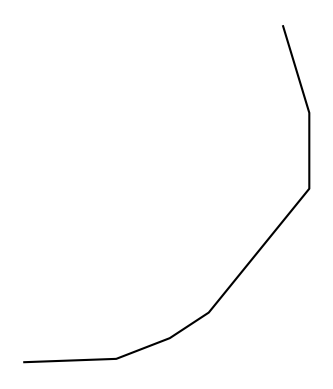

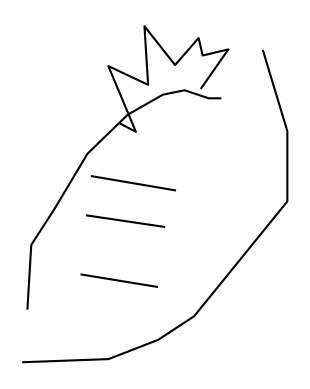

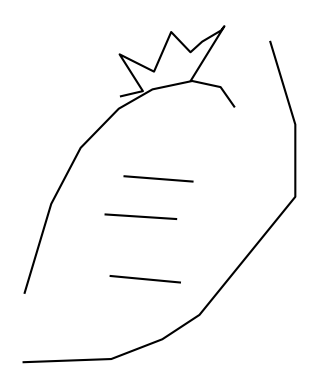

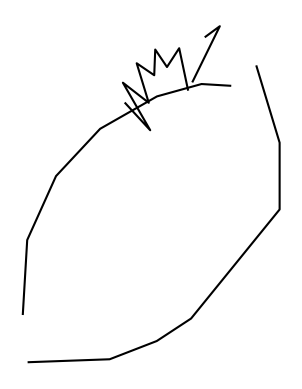

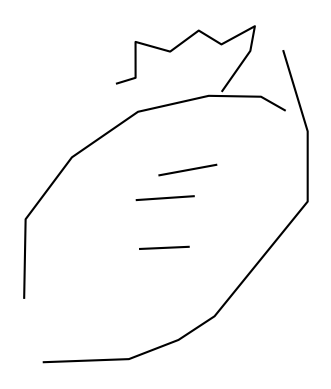

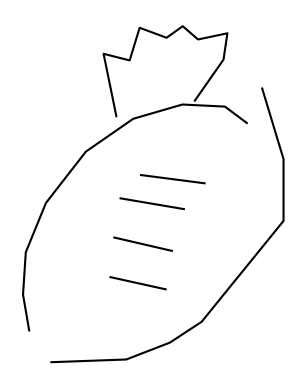

In [264]:

length = 6
end = torch.Tensor([0,0,0,0,1,0,0,0,0]).view((1,stroke_dim+Nclass))
N = 3
T = 0.1
curve = torch.Tensor([[-0.2871,  0.9499,  0.0000,  1.0000,  0.0000,  1.0000,  0.0000,  0.0000,0.0000],
                      [ 0.0000,  0.8311,  0.0000,  1.0000,  0.0000,  1.0000,  0.0000,  0.0000,0.0000],
                      [ 1.1022,  1.3577,  0.0000,  1.0000,  0.0000,  1.0000,  0.0000,  0.0000, 0.0000],
                      [ 0.4270,  0.2801,  0.0000,  1.0000,  0.0000,  1.0000,  0.0000,  0.0000,0.0000],
                      [ 0.5866,  0.2271,  0.0000,  1.0000,  0.0000,  1.0000,  0.0000,  0.0000,0.0000],
                      [ 1.0083,  0.0365,  0.0000,  1.0000,  0.0000,  1.0000,  0.0000,  0.0000,0.0000],
                      [ 0.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,0.0000]])

label = torch.cat([F.one_hot((torch.Tensor([N]).long()),Nclass).view(1,Nclass)]*batch_size,dim=0)


display_encoded_image(curve)

ntests = 5

for i in range(0, ntests):
    completion = model.complete_sketch(torch.stack([curve]*batch_size,dim=1)[:,:,:],label)
    display_encoded_image(completion[:, 0, :])
    

In [ ]:
nstep = 7
T =0.2

interp = latent_lerp(model,S1,S2,nstep)

for i in range(nstep):
    display_encoded_image(interp[i][:, 0, :])
